In [1]:
%run 0_parameters.ipynb


WELCOME



In [2]:
if not os.path.exists('figures/BCP'):
    os.makedirs('figures/BCP')


# the switching binomial generative model


In [3]:
t_titre = 35
t_label = 25
fig_width= 15
N_scan = 100
#N_scan = 10 # DEBUG

In [4]:
msfigpath = '../PasturelMontagniniPerrinet2019/figures'
observer = 'AM'
mode = 'pari'
from aSPEM import Analysis
import bayesianchangepoint as bcp
e = Analysis(observer=observer, mode=mode)

/!\ Le fichier Delete n'existe pas pour fct_velocity_2_step_False_whitening !


# the online BCP model: figures for the model

In [5]:
N_trials = 10 # 100
seed = 2020
np.random.seed(seed)
p0, r0 =  0.5, 1.0
trials = np.arange(N_trials)
p = np.random.rand(N_trials, 3)
p[:, 2] = 0
p[N_trials//2, 2] = 1

p[:N_trials//2, 1] = .3 #.15
p[N_trials//2:, 1] = .9 #.85

for trial in trials:
    p[trial, 0] =  p[trial, 1] > np.random.rand() # Bernouilli trial

tau = N_trials//2
h = 1/tau
p_bar, r_bar, beliefs = bcp.inference(p[:, 0], h=h, p0=p0, r0=r0)
p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='max', p0=p0)
p_hat, r_hat_mean = bcp.readout(p_bar, r_bar, beliefs, mode='mean', p0=p0)
p_hat, r_hat_leaky = bcp.readout(p_bar, r_bar, beliefs, mode='leaky', p0=p0)

print(r_hat)

[1. 2. 3. 4. 5. 6. 2. 3. 4. 5.]


In [6]:
print(beliefs)

[[1.         0.2        0.2        0.2        0.2        0.2
  0.2        0.2        0.2        0.2       ]
 [0.         0.8        0.22188351 0.14851195 0.12766258 0.11823668
  0.27377326 0.16470246 0.13307283 0.11977352]
 [0.         0.         0.57811649 0.22220202 0.12784584 0.10178351
  0.105425   0.30405538 0.14779204 0.10747607]
 [0.         0.         0.         0.42928603 0.21488698 0.11450839
  0.06756639 0.08681878 0.30650712 0.13409431]
 [0.         0.         0.         0.         0.3296046  0.20497035
  0.06058858 0.0443546  0.06948419 0.2961625 ]
 [0.         0.         0.         0.         0.         0.26050107
  0.09018002 0.03308642 0.02951196 0.05563022]
 [0.         0.         0.         0.         0.         0.
  0.20246675 0.04216611 0.01884746 0.02021634]
 [0.         0.         0.         0.         0.         0.
  0.         0.12481624 0.02100247 0.01128713]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.07378193 0.011174

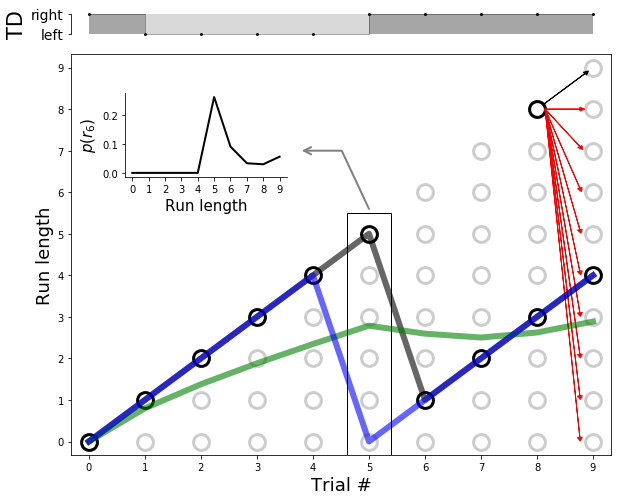

In [7]:
from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection

def arrow_1(ax, x, y, alpha):
    plt.arrow(x+r_cir, y+r_cir, 1-(r_cir*2)-(s_arrow/2), 1-(r_cir*2)-(s_arrow/2),
              head_width=s_arrow, head_length=s_arrow, fc=c_f1, ec=c_f1, alpha=alpha)


def arrow_2(ax, x, y, alpha):
    for r in range(0, y+1) :
        if r==0 : a=0
        else :    a=r_cir
        plt.arrow(x+r_cir+(s_arrow/2), y, 1-(r_cir*2)-(s_arrow*2), -r+a,
                  head_width=s_arrow, head_length=s_arrow, fc=c_f2, ec=c_f2, alpha=alpha)


r_true = r_hat.copy()
r_true[5:] = np.arange(1,6)
        
fig_width = 15
r_cir, lw_cir, s_arrow = 0.1, 3, 0.09 # 0.2, 3, 0.09
alpha = .2

c_f1, c_f2, c_cir = 'k', 'r', 'k'
labelsize = 18
num = N_trials


import matplotlib.gridspec as gridspec
#------------------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(fig_width, ((2+0.5)*fig_width/3)/(1.6180)))

gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0, bottom=0.85, right=0.5, top=1.-0.1, hspace=0.05)
axs[0] = plt.subplot(gs1[0])

axs[0].plot(np.arange(N_trials), p[:, 0], 'k.', ms=4)
for card in ['bottom', 'top', 'right']: axs[0].spines[card].set_visible(False)
axs[0].spines['left'].set_bounds(0, 1)
axs[0].set_yticks([0,1])
axs[0].set_yticklabels(['left','right'],fontsize=t_label/1.8)

ec = 0.2
color=[['k', 'k'], [color_true_p, color_true_p], ['k','none']]
Alpha = [[.35,.15],[.0,.0],[1,0]]


axs[0].step(range(N_trials), p[:, 0], lw=1, c=color[0][0], alpha=Alpha[0][0], where='post')
axs[0].fill_between(range(N_trials), np.zeros_like(p[:, 0]), p[:, 0],
                    lw=.5, alpha=Alpha[0][0], facecolor=color[0][0], step='post')
axs[0].fill_between(range(N_trials), np.ones_like(p[:, 0]), p[:, 0],
                    lw=.5, alpha=Alpha[0][1], facecolor=color[0][1], step='post')

axs[0].set_ylabel('TD', fontsize=t_label/1.2)
axs[0].set_xticks(())


gs2 = gridspec.GridSpec(1, 1)
gs2.update(left=0, bottom=0+0.1, right=0.5, top=0.85-0.03, hspace=0.05)
axs[1] = plt.subplot(gs2[0])
ax=axs[1]

for a in axs :
    a.set_xlim(-0.1,N_trials+0.1)

for x in trials:
    if x < num: runlengths = range(x+1)
    else:       runlengths = range(num)
    max_r = num-1
    
    for r in runlengths:
        ax.scatter(x, r, s=250, color='w', alpha=1 if r==r_hat[x]-1 else alpha, 
                  edgecolors=c_cir, lw=lw_cir)

        #if x < N_trials-1 :
            #arrow_1(ax, x, r, alpha=1 if r==r_hat[x]-1 else alpha)
            #arrow_2(ax, x, r, alpha=1 if r==r_hat[x]-1 else alpha)
    if x == N_trials-2 :
        r=N_trials-2
        arrow_1(ax, x, r, alpha=1)
        arrow_2(ax, x, r, alpha=1)
        ax.scatter(x, r, s=250, color='w', alpha=1, 
                  edgecolors=c_cir, lw=lw_cir)

ax.plot(r_hat-1, lw=6, alpha=0.6, c='k')
ax.plot(r_hat_mean-1, lw=6, alpha=0.6, c=color_bcp_mean)
#ax.plot(r_hat_leaky-1, lw=6, alpha=0.6, c=color_bcp_fix)
ax.plot(r_true-1, lw=6, alpha=0.6, c=color_true_p)

ax.tick_params(bottom=True, top=False, right=False, left=True)
ax.set_ylabel('Run length', fontsize=labelsize)
ax.set_xlabel('Trial #', fontsize=labelsize)
ax.set_xticks(trials)
ax.set_yticks(np.arange(0, N_trials))
ax.set_xticklabels(np.arange(0, N_trials))
ax.set_yticklabels(np.arange(0, N_trials))



num_t = 5

a1 = fig.add_axes([0.05, 0.6, 0.15,0.15])
a1.plot(beliefs[num_t], c='k', lw=2)
a1.set_xticks(np.arange(N_trials))
a1.set_ylabel('$p(r_6)$', fontsize=labelsize/1.2)
a1.set_xlabel('Run length', fontsize=labelsize/1.2)
for card in ['top', 'right']: a1.spines[card].set_visible(False)


ax.bar(num_t, num_t+2*0.5,  bottom=-0.5, color=(0,0,0,0), edgecolor='k')

connectionstyle = "arc,angleA=-90,angleB=0,armA=0,armB=40,rad=0"
ax.annotate("", xy=(3.8, 7), xytext=(num_t, num_t+0.6),
            arrowprops=dict(arrowstyle="->", #linestyle="dashed",
                            color="0.5",
                            shrinkA=0, shrinkB=0,
                            patchA=None, patchB=None,
                            connectionstyle=connectionstyle,
                            lw=2), fontsize=labelsize)

ax.axis([-0.32, (num+0.32)-1, -0.32, (num+0.32)-1])
axs[0].axis([-0.32, (num+0.32)-1, -ec, 1+ec])
#for ext in exts: plt.savefig('figures/BCP/bcp_model_layer_%s%s' % (layer, ext))

plt.show()

In [9]:
figname = '3_BCP_model'
for ext in exts: fig.savefig('{msfigpath}/{figname}'.format(msfigpath=msfigpath, figname=figname) + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)

# chosen readout with a comparison with 'fixed'

In [10]:
figname = '3_BCP_readouts'
num_block = 0

/usr/local/lib/python3.6/dist-packages/matplotlib/gridspec.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


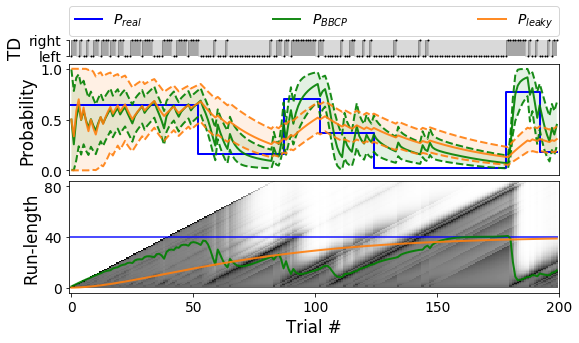

In [11]:
color = [['k', 'k'], [color_true_p, color_true_p], ['k','w']]
alpha = [[.35,.15],[.0,.0],[1,0]]
fig, ax1, ax2 = e.plot_bcp(mode=['mean'], mode_compare='leaky', block=num_block, trial=50, max_run_length=85, 
                           c_mode=color_bcp_mean, c_compare=color_bcp_fix, color=color,
                           N_scan=0, show_title=None, show_trial=False, fig_width=8, t_label=25,
                           leg_up=True, TD=True, alpha=alpha)
#for card in ['bottom', 'top']: 
#    ax1.spines[card].set_visible(False)
#    ax2.spines[card].set_visible(False)
##ax1.legend(loc='best')
#ax2.set_ylim(0, 80)
for ext in exts: fig.savefig('{msfigpath}/{figname}'.format(msfigpath=msfigpath, figname=figname) + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)
#for ext in exts: fig.savefig('figures/BCP/BCP_mean_leaky_0' + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)
fig.savefig('figures/BCP/BCP_mean_leaky_0.svg', dpi=dpi, bbox_inches='tight', pad_inches=0)

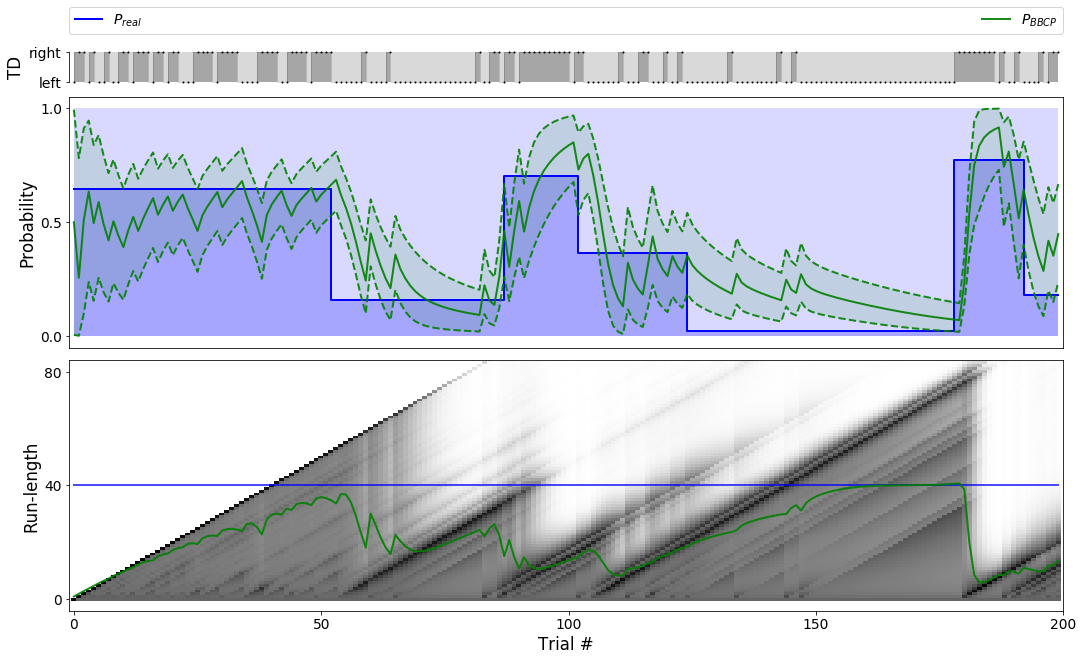

In [12]:
color = [['k', 'k'], [color_true_p, color_true_p], ['k','w']]
alpha = [[.35,.15],[.35,.15],[1,0]]
fig, ax1, ax2 = e.plot_bcp(mode=['mean'], mode_compare=None, block=num_block, trial=50, max_run_length=85, 
                           c_mode=color_bcp_mean, c_compare=color_bcp_fix, color=color,
                           N_scan=0, show_title=None, show_trial=False, TD=True,
                           fig_width=15, t_label=25, leg_up=True)#, pause=True) #fig_width=8, t_label=26, show_trial=False,leg_up=None)
for card in ['bottom', 'top']: 
    ax1.spines[card].set_visible(False)
    ax2.spines[card].set_visible(False)
#ax1.legend(loc='best')
ax2.set_ylim(0, 80)

#for ext in exts: fig.savefig('figures/BCP/BCP_mean_0' + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)
fig.savefig('figures/BCP/BCP_mean_0.svg', dpi=dpi, bbox_inches='tight', pad_inches=0)

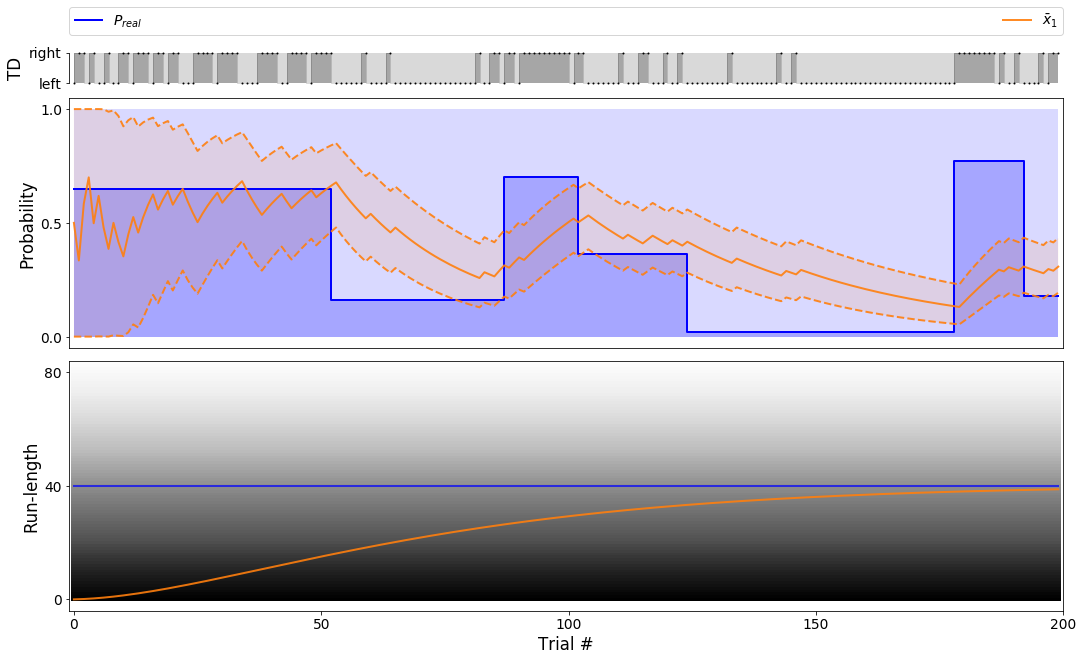

In [13]:
color = [['k', 'k'], [color_true_p, color_true_p], ['k','w']]
alpha = [[.35,.15],[.35,.15],[1,0]]
fig, ax1, ax2 = e.plot_bcp(mode=['leaky'], mode_compare=None, block=num_block, trial=50, max_run_length=85, 
                           c_mode=color_bcp_fix, c_compare=color_bcp_fix, color=color,
                           N_scan=0, show_title=None, show_trial=False, TD=True, label_bcp=r'$\bar{x}_1$',
                           fig_width=15, t_label=25, leg_up=True)#, pause=False) #fig_width=8, t_label=26, show_trial=False,leg_up=None)
for card in ['bottom', 'top']: 
    ax1.spines[card].set_visible(False)
    ax2.spines[card].set_visible(False)
#ax1.legend(loc='best')
ax2.set_ylim(0, 80)

#for ext in exts: fig.savefig('figures/BCP/BCP_leaky_0' + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)
fig.savefig('figures/BCP/BCP_leaky_0.svg', dpi=dpi, bbox_inches='tight', pad_inches=0)

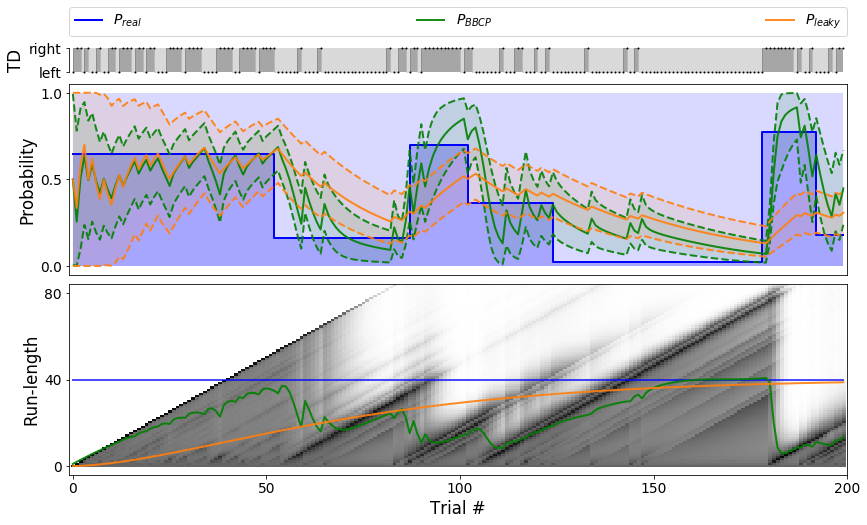

In [14]:
color = [['k', 'k'], [color_true_p, color_true_p], ['k','w']]
alpha = [[.35,.15],[.35,.15],[1,0]]
fig, ax1, ax2 = e.plot_bcp(mode=['mean'], mode_compare='leaky', block=num_block, trial=50, max_run_length=85, 
                           c_mode=color_bcp_mean, c_compare=color_bcp_fix, color=color,
                           N_scan=0, show_title=None, show_trial=False, TD=True,
                           fig_width=12, t_label=25, leg_up=True)#, pause=True) #fig_width=8, t_label=26, show_trial=False,leg_up=None)
for card in ['bottom', 'top']: 
    ax1.spines[card].set_visible(False)
    ax2.spines[card].set_visible(False)
#ax1.legend(loc='best')
ax2.set_ylim(0, 80)

#for ext in exts: fig.savefig('figures/BCP/BCP_mean_leaky_0' + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)
#for ext in exts: fig.savefig('{msfigpath}/{figname}_2'.format(msfigpath=msfigpath, figname=figname) + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)
fig.savefig('figures/BCP/BCP_mean_leaky_0.svg', dpi=dpi, bbox_inches='tight', pad_inches=0)


# evaluating the best hazard rate using a likelihood score

Vérifier tau !

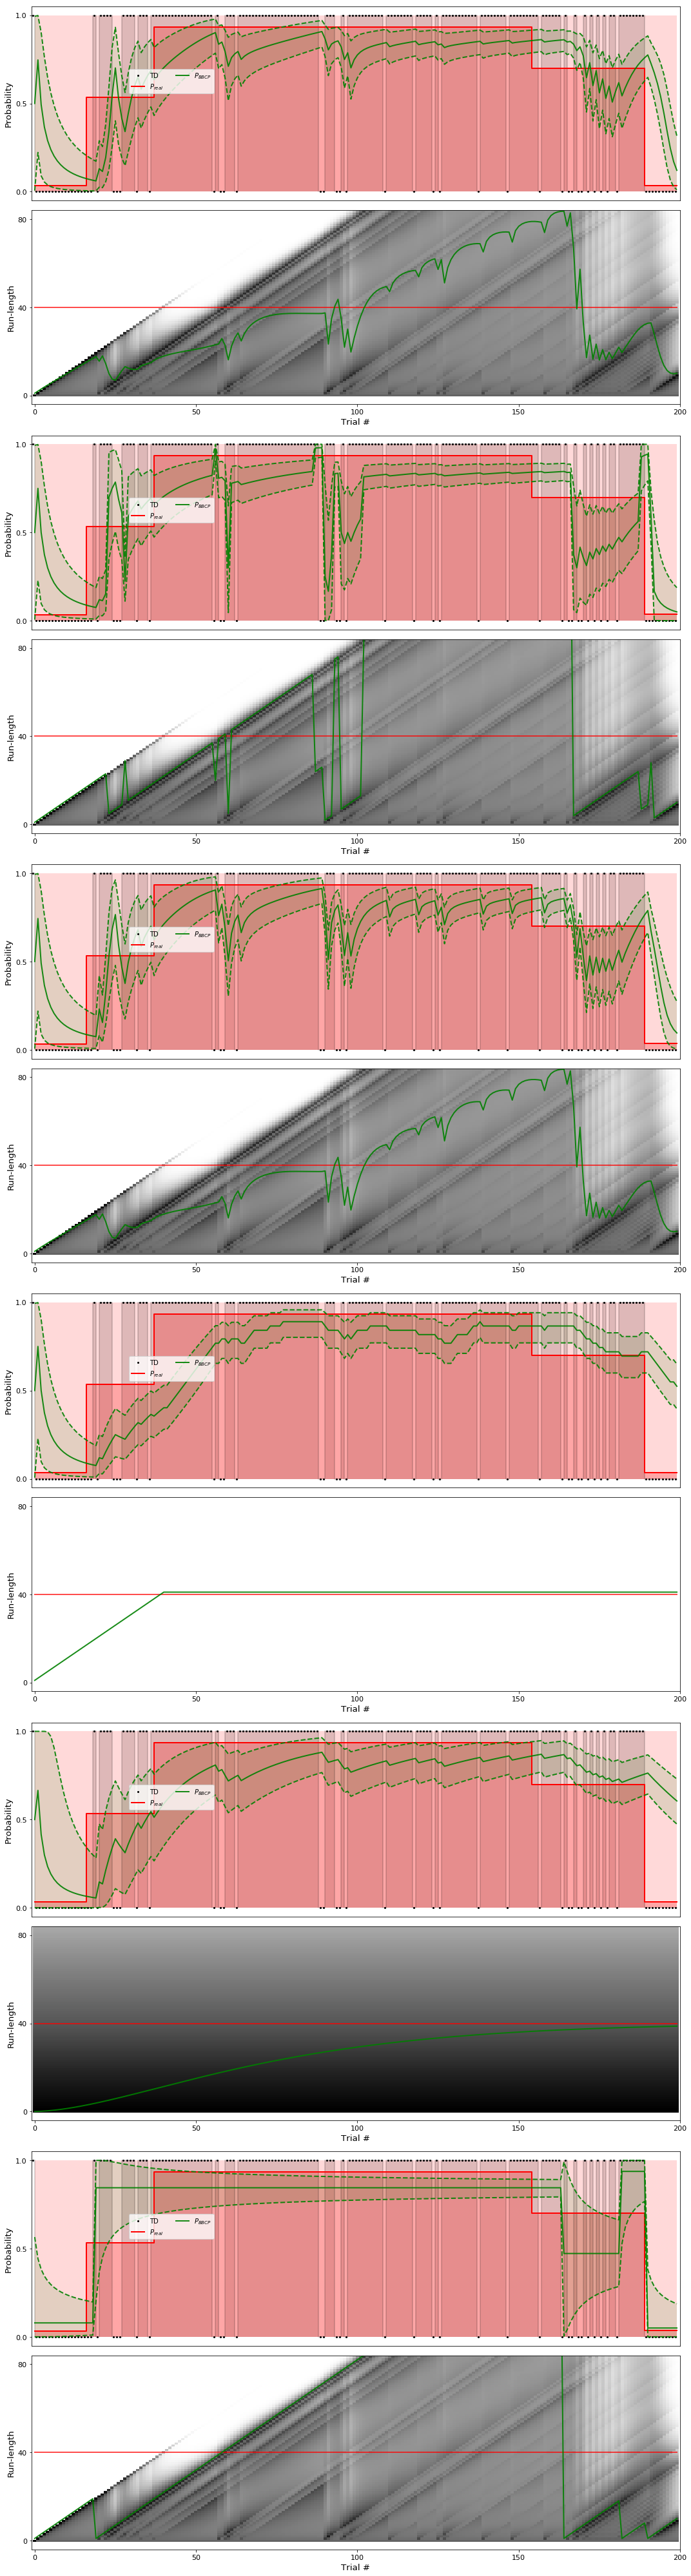

In [15]:
fig, ax1, ax2  = e.plot_bcp(show_trial=False, N_scan=0, block=2, trial=50)
#for ext in exts: fig.savefig('figures/BCP/BCP_readouts' + ext, dpi=dpi)
fig.savefig('figures/BCP/BCP_readouts.svg', dpi=dpi)

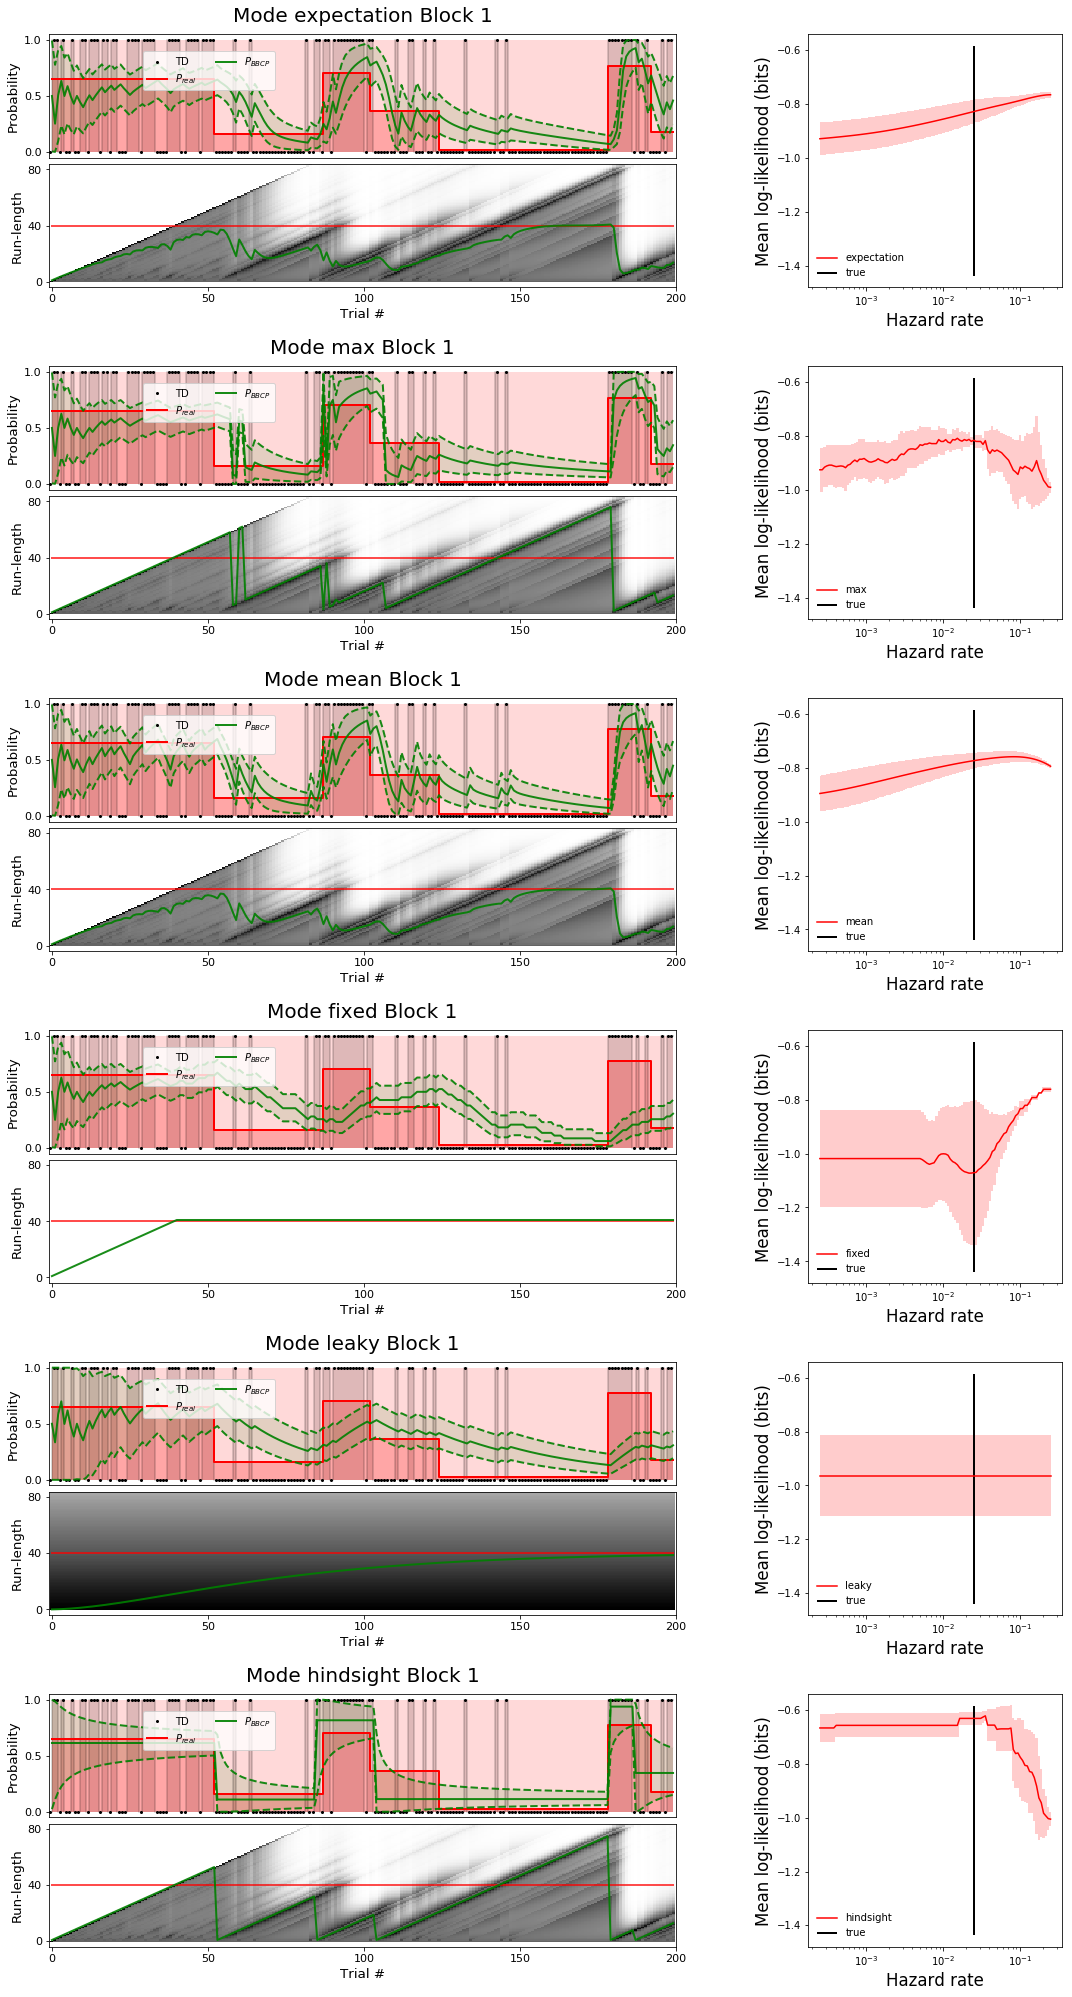

In [16]:
fig, ax1, ax2, ax3 = e.plot_bcp(show_trial=False, N_scan=N_scan)
#for ext in exts: fig.savefig('figures/BCP/BCP_scan' + ext, dpi=dpi)
fig.savefig('figures/BCP/BCP_scan.svg', dpi=dpi)

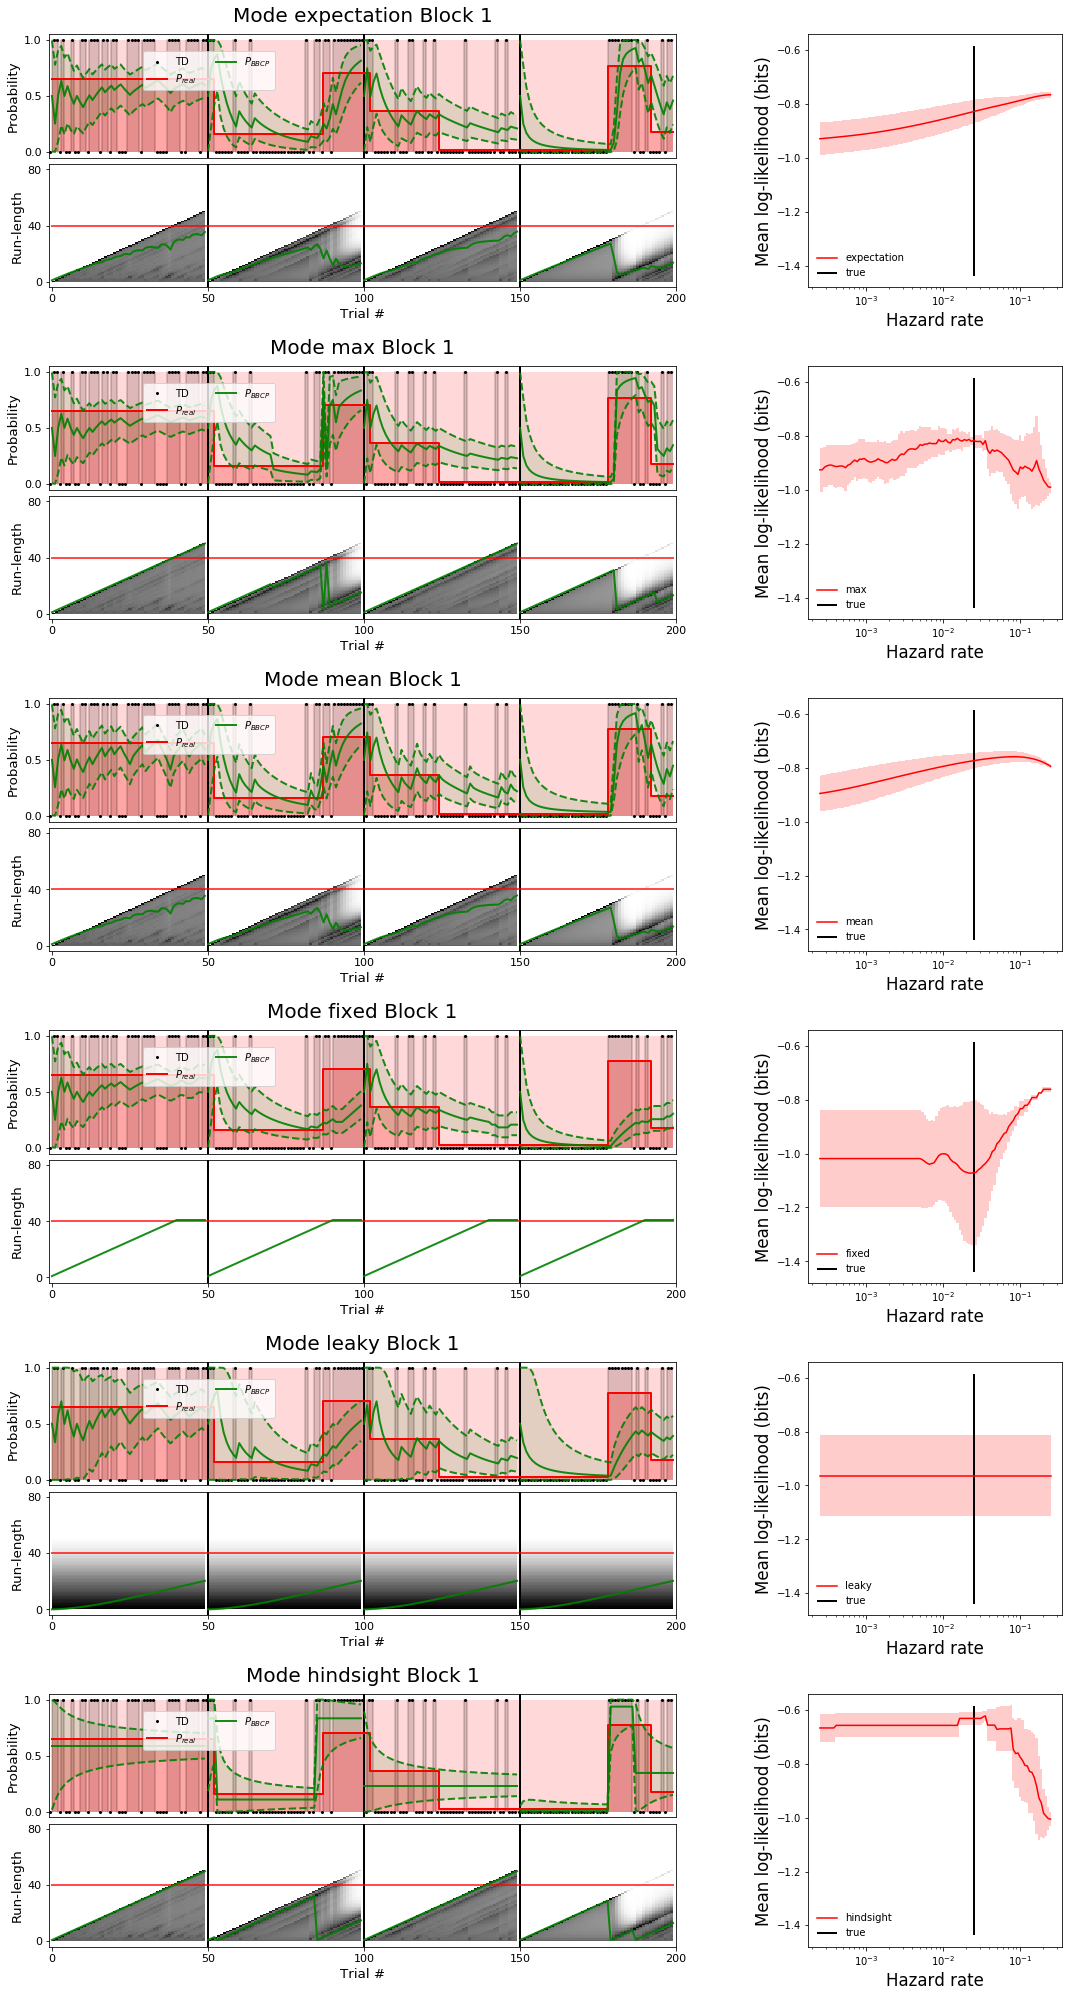

In [17]:
fig = e.plot_bcp(show_trial=False, N_scan=N_scan, pause=True)
#for ext in exts: fig.savefig('figures/BCP/BCP_scan' + ext, dpi=dpi)

TODO: plot pout chaque r la distriubtion Beta correspondant à $P(p |r) = B(p; p(r)*r, (1-p(r))*r)$

In [18]:
%ls {msfigpath}

1_A_Experiment_randomblock.pdf  3_BCP_model.pdf
1_B_protocol_recording.pdf      3_BCP_readouts.pdf
1_B_Trace_moyenne.pdf           4_A_result_psycho_aSPEM.pdf
1_C_protocol_bet.pdf            4_B_result_psycho_bet.pdf
2_results_enregistrement.pdf    5_inter-individual_differences_fit.pdf
